In [1]:
import numpy as np
import matplotlib.pyplot as plt

## 1
Измените функцию calc_logloss так, чтобы нули по возможности не попадали в np.log (как вариант - использовать np.clip или np.where).

Если я правильно понял задание, p не может равняться 0 и 1, т.к log(0) не существует и нам нужно заменить p на максимально приближенное к 0 или 1 число

In [2]:
def calc_logloss(y, p):   
    p = np.clip(p, 1e-4, 0.9999)
    err = np.mean(- y * np.log(p) - (1.0 - y) * np.log(1.0 - p))
    return err

In [3]:
# Пример применения
y = 0
p = 1 
calc_logloss(y, p)

9.210340371976294

In [4]:
y = 0
p = 0 
calc_logloss(y, p)

0.00010000500033334732

## 2
На данных из урока изучите влияние гиперпараметров на ошибку алгоритма.

In [5]:
X = np.array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
              [1, 1, 2, 1, 3, 0, 5, 10, 1, 2],  # стаж репетитора
              [500, 700, 750, 600, 1450,        # средняя стоимость занятия
               800, 1500, 2000, 450, 1000],
              [21, 25, 27, 20, 25, 18, 35, 60, 20, 30]],  # возраст репетитора
              dtype = np.float64).T 

y = np.array([0, 0, 1, 0, 1, 0, 1, 0, 1, 1]) # поступил или нет ученик на специальность Математика

In [6]:
def standardization(X):
    S = (X - X.mean(axis=0)) / X.std(axis=0)
    return S

X_st = X.copy()
X_st[:, 1:] = standardization(X[:, 1:])
X_st

array([[ 1.        , -0.57142857, -0.97958969, -0.60595294],
       [ 1.        , -0.57142857, -0.56713087, -0.264571  ],
       [ 1.        , -0.21428571, -0.46401617, -0.09388003],
       [ 1.        , -0.57142857, -0.77336028, -0.69129842],
       [ 1.        ,  0.14285714,  0.97958969, -0.264571  ],
       [ 1.        , -0.92857143, -0.36090146, -0.86198939],
       [ 1.        ,  0.85714286,  1.08270439,  0.58888384],
       [ 1.        ,  2.64285714,  2.11385144,  2.72252095],
       [ 1.        , -0.57142857, -1.08270439, -0.69129842],
       [ 1.        , -0.21428571,  0.05155735,  0.16215642]])

In [7]:
# логистическая регрессия
def eval_LR_model(X, y, iterations, eta=1e-4):
    np.random.seed(42)
    w = np.random.randn(X.shape[1])
    n = X.shape[0]
    for i in range(1, iterations + 1):
        z = np.dot(X, w) # log(p/(1-p))
        pred = sigmoid(z) # p [0, 1]
        err = calc_logloss(y, pred)
        w -= eta * (1/n * np.dot((pred - y), X))
#         if i % (iterations / 10) == 0:
#             print(i, w, err)
    return w, err

In [91]:
errors_list = []       
iterations = 2001
eta = [i for i in np.logspace(-4, -2, 5)]

for i in eta:
    err_list = [] 
    for iteration in range(1, iterations):     # Из-за этой строки код выполнялся очень долго, нужно было поставить шаг
        err_list.append(eval_LR_model(X_st, y, iteration, i)[1])
    errors_list.append(err_list)

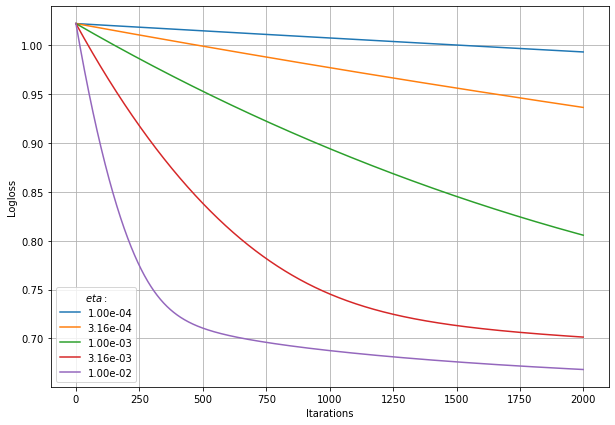

In [104]:
plt.figure(figsize = (10, 7))

for i in range(len(eta)):
    plt.plot(range(iterations-1), errors_list[i], label='{:.2e}'.format(eta[i]))
plt.xlabel('Itarations')
plt.ylabel('Logloss')
plt.grid()
plt.legend(title=r'$eta:$')

Как и в исследовании линейной регрессии мы видим уменьшение ошибки с увеличением количества итераций. Значения скорости обучения также сильно влияют на конечный результат. См. рис. выше

## 3
Создайте функцию calc_pred_proba, возвращающую предсказанную вероятность класса "1". На вход функции подаются значения признаков Х и веса, которые уже посчитаны функцией eval_LR_model.

In [8]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [9]:
def calc_pred_proba(X, w):
    return sigmoid(np.dot(X_st, w))

In [10]:
pred = calc_pred_proba(X_st, eval_LR_model(X_st, y, 1000, 1e-1)[0])
print('prob =', pred.round(2))
print('true =', y)

prob = [0.37 0.43 0.39 0.45 0.82 0.66 0.65 0.37 0.35 0.51]
true = [0 0 1 0 1 0 1 0 1 1]


## 4
Создайте функцию calc_pred, возвращающую предсказанные классы (0 или 1). На вход функции подаются значения признаков Х и веса, которые уже посчитаны функцией eval_LR_model, а также порог вероятности.

In [15]:
def calc_pred(X, w, prob_rate):
    pred = calc_pred_proba(X, w)
    return np.where(pred > prob_rate, 1, 0)

In [16]:
w = eval_LR_model(X_st, y, 1000, 1e-1)[0]
print(f'Пред: {calc_pred(X_st, w, 0.5)}')
print(f'Реал: {y}')

Пред: [0 0 0 0 1 1 1 0 0 1]
Реал: [0 0 1 0 1 0 1 0 1 1]


## 5
(*) Напишите функции для расчета accuracy, матрицы ошибок, precision и recall, а также F1-score.

In [17]:
predictions = calc_pred(X_st, w, 0.5)

In [24]:
TP = 0
FP = 0
TN = 0
FN = 0

for pos, i in enumerate(predictions):
    if i == y[pos] and i == 1:
        TP += 1
    elif i == y[pos] and i == 0:
        TN += 1
    elif i != y[pos] and i == 1:
        FP += 1
    else: FN += 1
    

def accuracy(TP, TN, FP, FN):
    return (TP + TN) / (TP + FP + TN + FN)


def mis_matrix(TP, TN, FP, FN):
    return np.array([[TP, FP], [FN, TN]])
                   


def prec_recall(TP, TN, FP, FN):
    prec = TP / (TP + FP)
    recall = TP / (TP + FN)
    return prec, recall


def f1_score(TP, TN, FP, FN):
    prec = prec_recall(TP, TN, FP, FN)[0]
    recall = prec_recall(TP, TN, FP, FN)[1]
    return 2 * (prec * recall) / (prec + recall)

In [22]:
TP, TN, FP, FN

(3, 4, 1, 2)

In [21]:
accuracy(TP, TN, FP, FN)

0.7

In [25]:
mis_matrix(TP, TN, FP, FN)

array([[3, 1],
       [2, 4]])

In [26]:
prec_recall(TP, TN, FP, FN)

(0.75, 0.6)

In [27]:
f1_score(TP, TN, FP, FN)

0.6666666666666665